In [63]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.models import load_model

In [45]:
IMAGE_WIDTH=40
IMAGE_HEIGHT=40
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [46]:
categories=[]
train_dir=os.listdir("train/train")
for filename in train_dir:
    category=filename.split('.')[0]
    if category == 'bonghwang':
        categories.append('bonghwang')
    if category == 'dohwa':
        categories.append('dohwa')
    if category == 'gongjak':
        categories.append('gongjak')
    if category == 'horang':
        categories.append('horang')
    if category == 'so':
        categories.append('so')
    if category == 'yong':
        categories.append('yong')

In [47]:
df=pd.DataFrame({'filename':train_dir,'category':categories})
df

,filename,category
0,bonghwang.00001.jpg,bonghwang
1,bonghwang.00002.jpg,bonghwang
2,bonghwang.00003.jpg,bonghwang
3,bonghwang.00004.jpg,bonghwang
4,bonghwang.00005.jpg,bonghwang
...,...,...
33352,yong.05716.jpg,yong
33353,yong.05717.jpg,yong
33354,yong.05718.jpg,yong
33355,yong.05719.jpg,yong


In [48]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [49]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

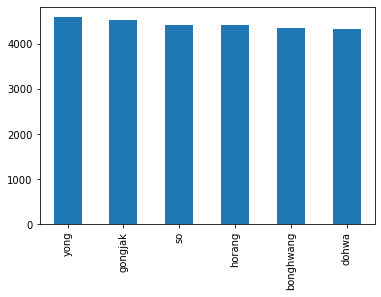

In [50]:
train_df['category'].value_counts().plot.bar()

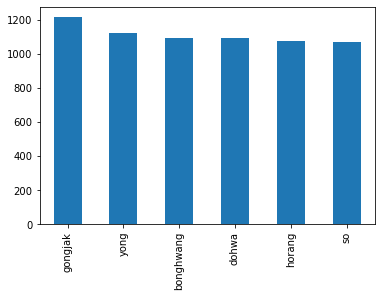

In [51]:
validate_df['category'].value_counts().plot.bar()

In [52]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [53]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                   rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

In [54]:
train_generator=train_datagen.flow_from_dataframe(train_df,
                                 'train/train/',
                                 x_col='filename',
                                 y_col='category',
                                  target_size=IMAGE_SIZE,
                                  class_mode='categorical',
                                  batch_size=batch_size
                                 )

Found 26685 validated image filenames belonging to 6 classes.


In [89]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(validate_df,
                                                              "train/train/",
                                                              x_col='filename',
                                                              y_col='category',
                                                              target_size=IMAGE_SIZE,
                                                              class_mode='categorical',
                                                              batch_size=batch_size)

Found 6672 validated image filenames belonging to 6 classes.


In [56]:
from keras.models import Sequential
from keras.layers import *

In [57]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax')) # 2 because we have cat and dog classes
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 38, 38, 32)        896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 38, 38, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 19, 19, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 17, 17, 64)        18496     
_________________________________________________________________
batch_normalization_9 (Batch (None, 17, 17, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)         

In [37]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [58]:
earlystop = EarlyStopping(patience=10),
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=2,
                                           verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [59]:
history = model.fit_generator(train_generator,
                              epochs=40,
                              validation_data=validation_generator,
                              validation_steps=total_validate//batch_size,
                              steps_per_epoch=total_train//batch_size,
                              callbacks=[earlystop,learning_rate_reduction])

Epoch 1/40
1779/1779 [==============================] - 75s 42ms/step - loss: 1.9277 - accuracy: 0.2605 - val_loss: 1.7470 - val_accuracy: 0.2734
Epoch 2/40
1779/1779 [==============================] - 70s 39ms/step - loss: 1.5787 - accuracy: 0.3560 - val_loss: 1.4437 - val_accuracy: 0.4038
Epoch 3/40
1779/1779 [==============================] - 66s 37ms/step - loss: 1.4533 - accuracy: 0.4199 - val_loss: 1.2967 - val_accuracy: 0.4962
Epoch 4/40
1779/1779 [==============================] - 72s 40ms/step - loss: 1.3662 - accuracy: 0.4576 - val_loss: 1.2978 - val_accuracy: 0.4832
Epoch 5/40
1779/1779 [==============================] - 77s 43ms/step - loss: 1.3102 - accuracy: 0.4831 - val_loss: 1.0048 - val_accuracy: 0.6180
Epoch 6/40
1779/1779 [==============================] - 77s 43ms/step - loss: 1.2502 - accuracy: 0.5091 - val_loss: 1.1953 - val_accuracy: 0.5622
Epoch 7/40
1779/1779 [==============================] - ETA: 0s - loss: 1.2106 - accuracy: 0.5244
Epoch 00007: ReduceLROnPla

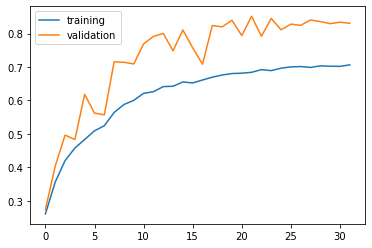

In [60]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [61]:
model.evaluate(train_generator)

1779/1779 [==============================] - 38s 21ms/step - loss: 0.4928 - accuracy: 0.82993s - loss: 0.4926 - accuracy


[0.4927530586719513, 0.8299044370651245]

In [62]:
model.save("model_face_83.h5")

In [65]:
loaded_model = load_model('model_face_83.h5')
loaded_model.evaluate(train_generator)

1779/1779 [==============================] - 39s 22ms/step - loss: 0.4914 - accuracy: 0.8274


[0.49139395356178284, 0.827356219291687]

### pretrained model을 통한 예측

In [117]:
categories=[]
train_dir=os.listdir("faces")
for filename in train_dir:
    category=filename.split('_')[0]
    if category == 'bonghwang':
        categories.append('bonghwang')
    if category == 'dohwa':
        categories.append('dohwa')
    if category == 'gongjak':
        categories.append('gongjak')
    if category == 'horang':
        categories.append('horang')
    if category == 'so':
        categories.append('so')
    if category == 'yong':
        categories.append('yong')

In [118]:
categories

['bonghwang',
 'bonghwang',
 'bonghwang',
 'bonghwang',
 'bonghwang',
 'bonghwang',
 'gongjak',
 'gongjak',
 'gongjak',
 'gongjak']

In [119]:
df=pd.DataFrame({'filename':train_dir,'category':categories})
df

,filename,category
0,bonghwang_1.jpg,bonghwang
1,bonghwang_2.jpg,bonghwang
2,bonghwang_3.jpg,bonghwang
3,bonghwang_4.jpg,bonghwang
4,bonghwang_5.jpg,bonghwang
5,bonghwang_6.jpg,bonghwang
6,gongjak_1.jpg,gongjak
7,gongjak_2.jpg,gongjak
8,gongjak_3.jpg,gongjak
9,gongjak_4.jpg,gongjak


In [120]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(df,
                                 'faces/',
                                 x_col='filename',
                                 y_col='category',
                                  target_size=IMAGE_SIZE,
                                  class_mode='categorical',
                                  batch_size=batch_size)

Found 10 validated image filenames belonging to 2 classes.


In [121]:
output = loaded_model.predict_generator(validation_generator,steps = 1)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(validation_generator.class_indices)
print(output)

{'bonghwang': 0, 'gongjak': 1}
[[0.067 0.022 0.820 0.000 0.089 0.003]
 [0.995 0.003 0.000 0.000 0.001 0.001]
 [0.000 0.000 0.010 0.000 0.000 0.989]
 [0.067 0.022 0.820 0.000 0.089 0.003]
 [0.440 0.296 0.085 0.000 0.179 0.000]
 [0.287 0.099 0.424 0.014 0.174 0.002]
 [0.989 0.001 0.009 0.000 0.001 0.000]
 [0.966 0.018 0.002 0.000 0.005 0.008]
 [0.000 0.000 0.008 0.000 0.000 0.992]
 [0.440 0.296 0.085 0.000 0.179 0.000]]


In [122]:
test=[]
print(len(output))
for i in output:
    test.append(i.argmax())

10


In [123]:
test

[2, 0, 5, 2, 0, 2, 0, 0, 5, 0]

In [136]:
dap = [0,0,0,0,0,0,1,1,1,1]

In [137]:
acc = []
for i in range(10):
    if test[i] == dap[i]:
        acc.append(1)
    else:
        acc.append(0)

In [138]:
acc

[0, 1, 0, 0, 1, 0, 0, 0, 0, 0]

NameError: name 'ᄆᄎᄎ' is not defined